# Enobio Motor Screening (CSP)
Use this notebook to test running Common Spatial Pattern (CSP) based Motor Imagery classification through MNE (2019.01.17).

Following this tutorial https://martinos.org/mne/stable/auto_examples/decoding/plot_decoding_csp_eeg.html#sphx-glr-auto-examples-decoding-plot-decoding-csp-eeg-py

In [74]:
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from matplotlib import pyplot as plt
from mne.filter import filter_data
import scipy.signal as scisig
import numpy as np
import pandas as pd
import csv
import mne

Function to convert .easy files from NIC2 (recording software for Enobio) to Pandas dataframe

In [3]:
def ConvertEasyToDataFrame(filename):
    """ This function converts a single .easy file (from NIC2) to an easy-to-use dataframe.
    Uses both the .easy file and .info file (containing metadata)
    
    ---- Input ----
    filename: string containing the .easy filepath
    
    ---- Output ----
    df: dataframe containing all the EEG, accelerometer, and event marker data
    fs: sampling rate for the EEG data (Hz)
    fs_accel: sampling rate for the accelerometer data (Hz)
    
    """
    import pandas as pd
    
    # Read in the .easy file
    df = pd.read_csv(filename, delimiter='\t', header=None)
    
    # Get metadata from the .info file
    fname = filename[:-5] + '.info'
    with open(fname) as f:
        content = f.readlines()
    content = [x.strip() for x in content]
    
    # Get the channel names
    channel_info = [x for x in content if 'Channel ' in x]
    channel_names = []
    for ch in range(len(channel_info)):
        channel_names.append(channel_info[ch].split(': ')[1])
        
    channel_names.append('X')
    channel_names.append('Y')
    channel_names.append('Z')
    channel_names.append('STI 014')
    channel_names.append('DateTime')
    
    # Get sampling rates
    sampling_rates = [x for x in content if 'sampling rate: ' in x]
    fs_all = []
    for freq in range(len(sampling_rates)):
        fs_all.append(float(sampling_rates[freq].split(': ')[1].split(' ')[0]))

    # Store sampling rates
    fs = fs_all[0]
    fs_accel = fs_all[1]
    
    # Assign the column names
    df.columns = channel_names
    
    # Return dataframe and sampling rates
    return df, fs, fs_accel

## Variables to Set

In [2]:
subjID = 'nile'
filename_eeg = '../data/Enobio/20190109103635_nile_motor_screening_R1.easy'
filename_behavioral = '../data/Enobio/nile_Motor_Screening_R1.csv'

## Load the EEG data
Load in the data from the NIC2 .easy file and convert to a Pandas dataframe

In [4]:
EEGdata, fs, fs_accel = ConvertEasyToDataFrame(filename_eeg)
EEGdata.head()

,Fz,FC1,Cz,C3,C4,Pz,P3,P4,X,Y,Z,STI 014,DateTime
0,-64218719,-91824399,-8338166,-2030945,-49758630,-2714348,-14760972,-96655237,0,0,0,0,1547058995082
1,-64229019,-91834126,-8313513,-2063131,-49748140,-2760029,-14809848,-96646272,0,0,0,0,1547058995084
2,-64314420,-91799603,-8309317,-2039480,-49770408,-2718305,-14765502,-96629869,0,0,0,0,1547058995086
3,-64416797,-91751157,-8329821,-1985502,-49809080,-2631378,-14674283,-96621715,0,0,0,0,1547058995088
4,-64524849,-91692363,-8367157,-1904297,-49862247,-2502680,-14540435,-96621334,647,9590,-647,0,1547058995090


In [5]:
# Check shape of the data
np.shape(EEGdata)

(324321, 13)

## Load the behavioral data

In [6]:
behavioralData = pd.read_csv(filename_behavioral, ',')
behavioralData = behavioralData.transpose()

# Saving header information
behavioralHeader = behavioralData.iloc[0]

behavioralData = behavioralData.iloc[2:]
behavioralData.columns = behavioralHeader
behavioralData.head()

Unnamed: 0,trialStart,stimulus,trialLength,trialType
trial_0,20.627180866897106,right,4,R
trial_1,26.05218400293961,right,4,R
trial_2,31.890687201870605,right,4,R
trial_3,37.855548202292994,left,4,L
trial_4,43.127350472146645,left,4,L


## Convert data into MNE format

### Convert stimulus channel data to indicate either left or right trial

In [9]:
# Create lists for each trial type
trialL = list()
trialR = list()
i = 0

for letter in behavioralData['trialType'][1:]:
    if letter == 'L':
        trialL.append(i)
    elif letter == 'R':
        trialR.append(i)
    i += 1

# Create a single list that includes which trial is which
trial_type = list()
i = 0

for letter in behavioralData['trialType'][1:]:
    if letter == 'L':
        trial_type.append(1)
    elif letter == 'R':
        trial_type.append(2)
    i += 1

stim_data = EEGdata['STI 014']
cnt = 0
for i in range(0, len(stim_data)):
    if stim_data[i] > 0:
        stim_data[i] = trial_type[cnt]
        cnt += 1

# Reassign new stim values to EEGdata['STI 014']
EEGdata['STI 014'] = stim_data

### Save as MNE raw object

In [10]:
channels = list(EEGdata.columns[0:7])
channels.append('STI 014')

ch_types = ['eeg']*(len(channels)-1)
ch_types.append('stim')
info = mne.create_info(ch_names=channels, sfreq=fs, ch_types=ch_types)

rawData = EEGdata[channels].values
rawData = np.transpose(rawData)

raw = mne.io.array.RawArray(rawData, info)

Creating RawArray with float64 data, n_channels=8, n_times=324321
    Range : 0 ... 324320 =      0.000 ...   648.640 secs
Ready.


### Artifact Removal via ICA
First, make a copy of our data and format it such that it can be used with MNE python. Follow tutorial from here https://martinos.org/mne/stable/auto_tutorials/plot_artifacts_correction_ica.html

But this page was more useful https://cbrnr.github.io/2018/01/29/removing-eog-ica/

In [11]:
raw.filter(l_freq=1, h_freq=40)

Setting up band-pass filter from 1 - 40 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Filter length of 1651 samples (3.302 sec) selected


<RawArray  |  None, n_channels x n_times : 8 x 324321 (648.6 sec), ~19.8 MB, data loaded>

<IPython.core.display.Javascript object>


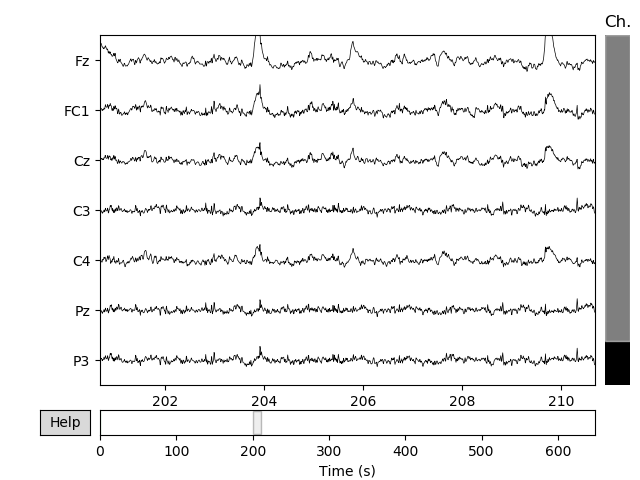

In [12]:
%matplotlib notebook
fig = raw.plot(n_channels=7, scalings='auto')

In [13]:
raw.set_montage(mne.channels.read_montage(kind='standard_1020'))

<RawArray  |  None, n_channels x n_times : 8 x 324321 (648.6 sec), ~19.8 MB, data loaded>

In [14]:
n_components = 7
method = 'fastica'
random_state = 23
ica = mne.preprocessing.ICA(n_components=n_components, method=method, random_state=random_state)

In [15]:
reject = dict(mag=5e-12, grad=4000e-13)
ica.fit(raw, reject=reject)
print(ica)

Fitting ICA to data using 7 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 7 components
Fitting ICA took 1.1s.
<ICA  |  raw data decomposition, fit (fastica): 324000 samples, 7 components, channels used: "eeg">


<IPython.core.display.Javascript object>


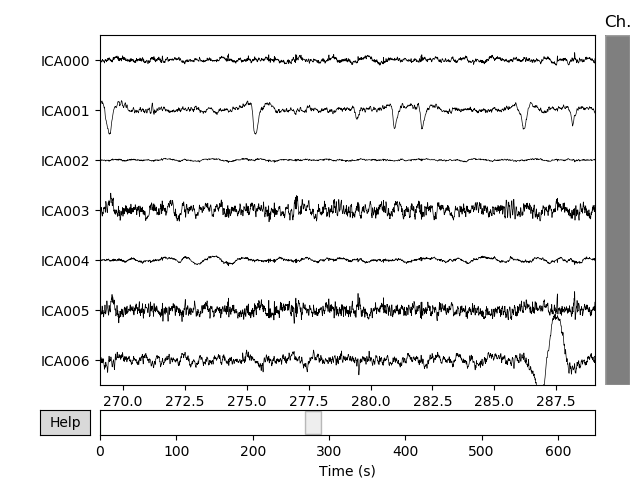

In [16]:
%matplotlib notebook
fig = ica.plot_sources(raw)

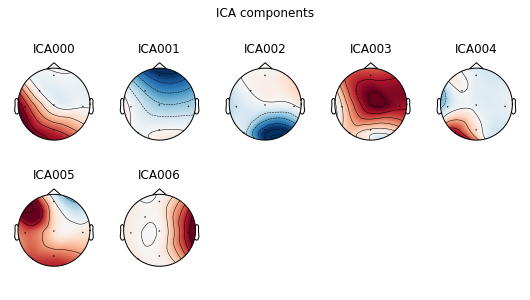

[<Figure size 540x288 with 10 Axes>]

In [17]:
%matplotlib inline
ica.plot_components()

    using multitaper spectrum estimation with 7 DPSS windows


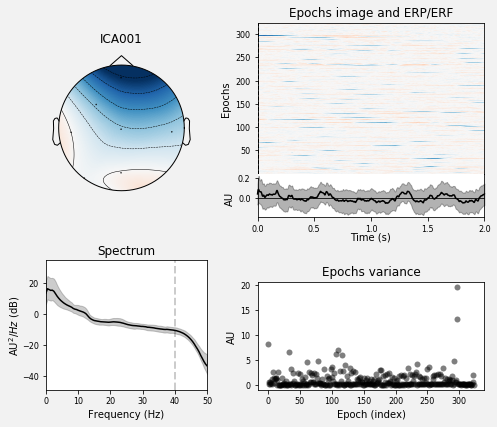

[<Figure size 504x432 with 5 Axes>]

In [18]:
# Take a closer look at an individual component
%matplotlib inline
ica.plot_properties(raw, picks=[1])

### Remove artifacts
Find likely artifacts, remove from signal, and reconstruct signal, then reassign to the dataframe format (to work with in the rest of the code)

In [19]:
ica.exclude = [1] # most likely to be blinks (when you check source you can see clearly)

In [20]:
raw_corrected = raw.copy()
ica.apply(raw_corrected)

Transforming to ICA space (7 components)
Zeroing out 1 ICA components


<RawArray  |  None, n_channels x n_times : 8 x 324321 (648.6 sec), ~19.8 MB, data loaded>

<IPython.core.display.Javascript object>


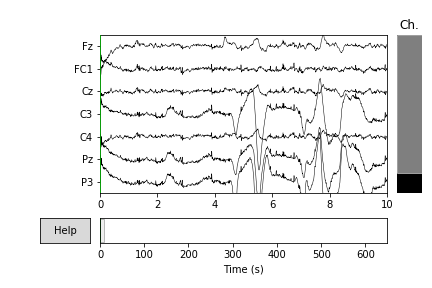

<IPython.core.display.Javascript object>


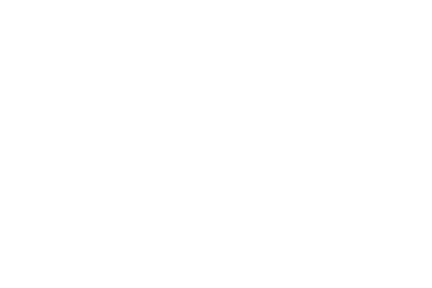

In [21]:
# Plot original
%matplotlib notebook
fig = raw.plot(n_channels = 7, scalings='auto')

<IPython.core.display.Javascript object>


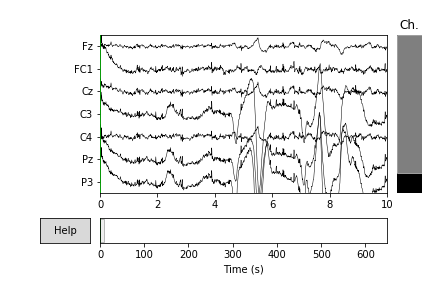

<IPython.core.display.Javascript object>


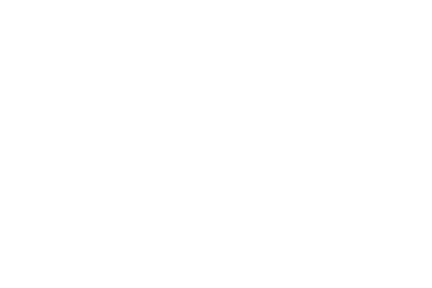

In [22]:
# Plot corrected
fig = raw_corrected.plot(n_channels = 7, scalings='auto')

## Epoch the data for classification
Try using both raw_corrected and just raw. Just raw seems to do better?

In [102]:
raw.info

<Info | 17 non-empty fields
    bads : list | 0 items
    buffer_size_sec : float | 1.0
    ch_names : list | Fz, FC1, Cz, C3, C4, Pz, P3, STI 014
    chs : list | 8 items (EEG: 7, STIM: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    dig : list | 10 items
    events : list | 0 items
    highpass : float | 1.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 40.0 Hz
    nchan : int | 8
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 500.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_date : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
    xplot

In [103]:
# Two types of events, 1 = left hand MI, 2 = right hand MI
events = mne.find_events(raw, shortest_event=0, stim_channel='STI 014')

99 events found
Event IDs: [1 2]


In [104]:
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')

In [105]:
tmin = 0
tmax = 4
event_id = list(events[:,2]) # the event ID numbers
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks, baseline=None, preload=True)

99 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 99 events and 2001 original time points ...
0 bad epochs dropped


In [106]:
epochs_train = epochs.copy().crop(tmin=1., tmax=4.)
labels = epochs.events[:, -1] - 2

## Classify epochs
First, define a monte-carlo cross-validation generator (reduce variance):

In [107]:
scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

Assemble a classifier

In [108]:
#clf0 = LinearDiscriminantAnalysis()
clf0 = svm.SVC()
csp = mne.decoding.CSP(n_components=4, reg=None, log=True, norm_trace=False)

Use scikit-learn Pipeline with cross_val_score function

In [109]:
clf = Pipeline([('CSP', csp), ('LDA', clf0)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)

Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.


C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this war

Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.


C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this war

Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.


C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this war

Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.


C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Print the results

In [110]:
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print('Classification accuracy: %f / Chance level: %f' % (np.mean(scores), class_balance))

Classification accuracy: 0.625000 / Chance level: 0.505051


Plot CSP patterns estimated on full data for visualization

Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.


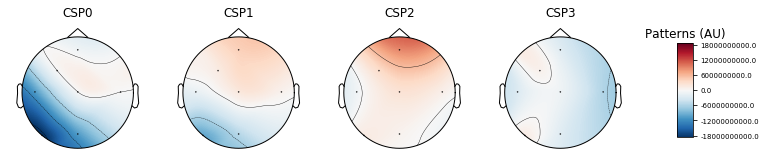

In [111]:
csp.fit_transform(epochs_data, labels)
layout = mne.channels.read_layout('EEG1005')
%matplotlib inline
fig = csp.plot_patterns(epochs.info, layout=layout, ch_type='eeg', units='Patterns (AU)', size=1.5)

Look at performance over time

Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.


C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.


C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.


C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.


C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.


C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


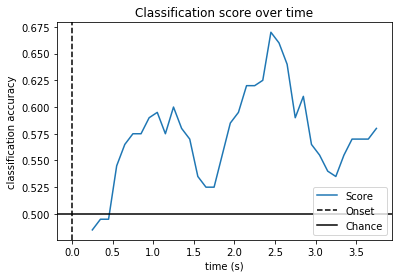

In [112]:
sfreq = raw_corrected.info['sfreq']
w_length = int(sfreq * 0.5)   # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    clf0.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        score_this_window.append(clf0.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()